# Problem: Forecasting Stock Prices using Time Series Modeling

## Method: E-GARCH
## Data: FTSE MIB Index from Investing.com
## Libraries:
- numpy
- pandas
- statsmodels
- requests
- plotly

## Method: E-GARCH


c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


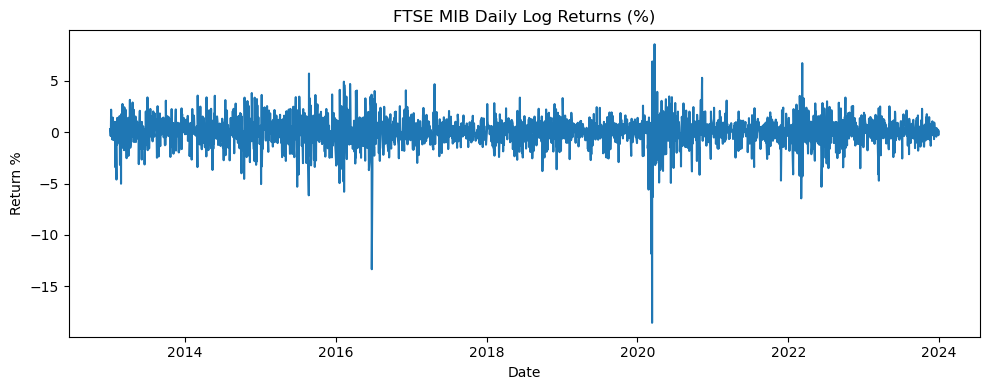

Dickey-Fuller p-value: 0.0000
ARCH LM-test p-value: 0.0000
Selected order: (2, 2, 1) with dist t
Test RMSE: 0.8805
Test MAE: 0.7153
Test MAPE: 588.25%
Test R^2: 0.3173
Test QLIKE: 1.6671


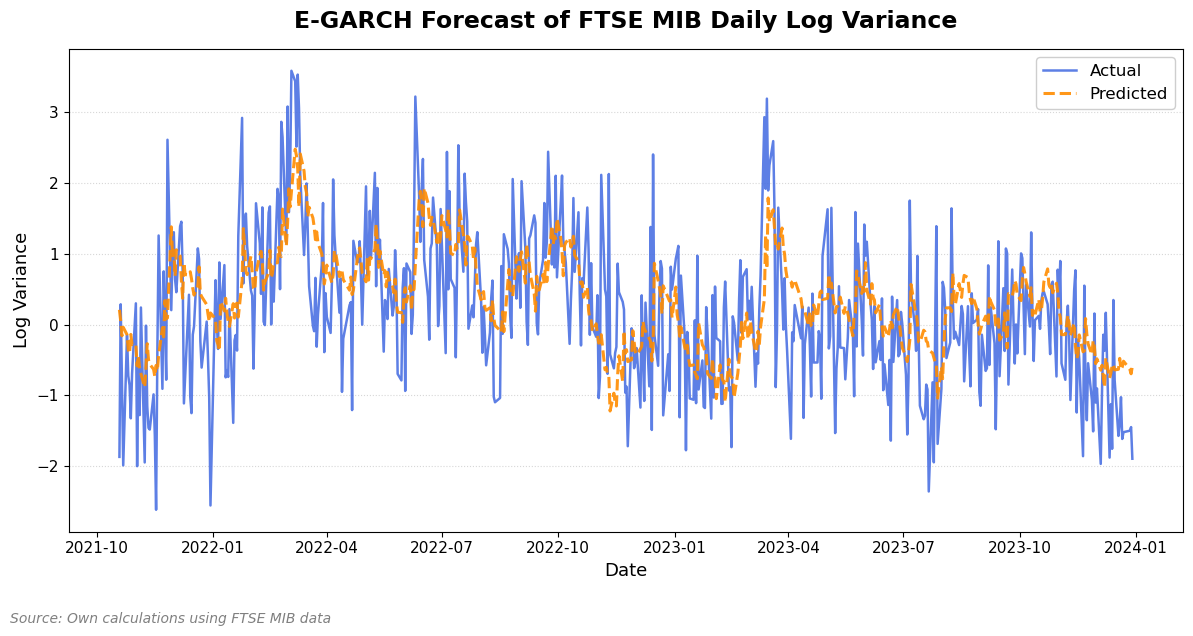

Next day predicted variance (%^2): 0.5133
Model AIC: 9001.39
Model BIC: 9072.67
Model Log-Likelihood: -4488.69
Std resid mean: -0.0468, std: 1.0069
Ljung-Box p-value (lag 10): nan


In [6]:
"""EGARCH volatility forecasting for the FTSE MIB.

This script cleans the data and computes daily log returns.  It tests for
stationarity and ARCH effects before selecting an EGARCH specification via
a small grid search.  The model uses log volume together with lagged
realized volatility and past shocks as exogenous regressors in the mean
equation and forecasts the log conditional variance rather than the raw
variance.  Forecasted variance is evaluated against a range-based
volatility proxy on an 80/20 split of the data.  Standardised residuals are
printed to ensure the specification captures volatility clustering.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from arch import arch_model
import itertools

# 1. Load data
file_path = "dataftsemib_manual.csv"

df = pd.read_csv(file_path)

# 2. Clean data
# Parse dates
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Numeric columns with commas
num_cols = ["Price", "Open", "High", "Low"]
for col in num_cols:
    df[col] = df[col].str.replace(",", "")
    df[col] = df[col].astype(float)

# Volume column (M/B suffix)

def parse_volume(v: str) -> float:
    v = str(v).strip()
    if v.endswith("M"):
        return float(v[:-1].replace(",", "")) * 1e6
    if v.endswith("B"):
        return float(v[:-1].replace(",", "")) * 1e9
    return float(v.replace(",", ""))


df["Vol."] = df["Vol."].apply(parse_volume)
df["Vol."].fillna(method="ffill", inplace=True)

# Change percent column
change = df["Change %"].str.replace("%", "").str.replace(",", ".")
df["Change %"] = change.astype(float)

# Sort by date and reset index

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# 3. Calculate log returns (percent)
df["Return"] = np.log(df["Price"]).diff() * 100
# Additional features for volatility modelling
df["LogVol"] = np.log(df["Vol."])
df["Range"] = (np.log(df["High"]) - np.log(df["Low"])) * 100

# Drop initial NaN from return difference
df.dropna(inplace=True)

# Realized variance proxy combining squared returns and range
df["RealizedVar"] = 0.5 * df["Return"].pow(2) + 0.5 * df["Range"].pow(2)
# Lagged realized variance and past shock magnitude for EGARCH-X
df["RV_lag1"] = df["RealizedVar"].shift(1)
df["AbsShockLag1"] = df["Return"].abs().shift(1)
df["LogRV"] = np.log(df["RealizedVar"])

# Drop rows introduced by lagging
df.dropna(inplace=True)

# After dropping the lagged observations ensure the return series and
# corresponding dates align with the exogenous variables.
returns = df["Return"].copy()
return_dates = df["Date"].copy()

exog = df[["LogVol", "RV_lag1", "AbsShockLag1"]]

# Plot returns
plt.figure(figsize=(10, 4))
plt.plot(return_dates, returns)
plt.title("FTSE MIB Daily Log Returns (%)")
plt.xlabel("Date")
plt.ylabel("Return %")
plt.tight_layout()
plt.savefig("returns_plot.png")
plt.show()
plt.close()

# 4. Stationarity test
adf_stat, adf_p, *_ = adfuller(returns)
print(f"Dickey-Fuller p-value: {adf_p:.4f}")

# 5. ARCH effect test
lm_stat, lm_p, _, _ = het_arch(returns)
print(f"ARCH LM-test p-value: {lm_p:.4f}")

# 6. Train/test split
split = int(len(returns) * 0.8)
train, test = returns[:split], returns[split:]
exog_train, exog_test = exog[:split], exog[split:]
rv_train, rv_test = df["RealizedVar"][:split], df["RealizedVar"][split:]
log_rv_train, log_rv_test = df["LogRV"][:split], df["LogRV"][split:]

# 7. Grid search for EGARCH(p,o,q) order using AIC
orders = [(1, 1, 1), (2, 1, 1), (1, 2, 2), (2, 2, 1)]
dists = ["t", "ged"]
best_order = orders[0]
best_dist = dists[0]
best_aic = float("inf")
for order, dist in itertools.product(orders, dists):
    try:
        am = arch_model(
            train,
            x=exog_train,
            mean="ARX",
            lags=1,
            vol="EGARCH",
            p=order[0],
            o=order[1],
            q=order[2],
            dist=dist,
        )
        res = am.fit(disp="off")
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = order
            best_dist = dist
    except Exception:
        continue
print("Selected order:", best_order, "with dist", best_dist)

# 8. Rolling one-step forecast on test set
history_y = train.copy()
history_x = exog_train.copy()
forecast_var = []
forecast_logvar = []
# Extract numpy arrays of the exogenous variables for efficiency
exog_arrays = {col: exog_test[col].values for col in exog.columns}
n_forecasts = min(len(test), *(len(v) for v in exog_arrays.values()))
test = test.iloc[:n_forecasts]
for i in range(n_forecasts):
    am = arch_model(
        history_y,
        x=history_x,
        mean="ARX",
        lags=1,
        vol="EGARCH",
        p=best_order[0],
        o=best_order[1],
        q=best_order[2],
        dist=best_dist,
    )
    res = am.fit(disp="off")
    # Provide the exogenous values for the forecast as 1-D arrays so that
    # ``arch`` can build a DataFrame without triggering index errors.
    fc = res.forecast(
        horizon=1,
        x={col: exog_arrays[col][i : i + 1] for col in exog.columns},
    )
    var = fc.variance.iloc[-1, 0]
    forecast_var.append(var)
    forecast_logvar.append(np.log(var))
    history_y = pd.concat([history_y, pd.Series([test.iloc[i]])], ignore_index=True)
    history_x = pd.concat([history_x, exog_test.iloc[i:i+1]], ignore_index=True)

forecast = pd.Series(forecast_logvar, index=test.index[: len(forecast_logvar)])

log_rv_test_trunc = log_rv_test.iloc[: len(forecast)]
rv_test_trunc = rv_test.iloc[: len(forecast)]
rmse = np.sqrt(mean_squared_error(log_rv_test_trunc, forecast))
mae = mean_absolute_error(log_rv_test_trunc, forecast)
mape = mean_absolute_percentage_error(log_rv_test_trunc, forecast)
r2 = r2_score(log_rv_test_trunc, forecast)
qlike = np.mean(np.log(np.maximum(forecast_var, 1e-8)) + rv_test_trunc.values / np.maximum(forecast_var, 1e-8))
print(
    f"Test RMSE: {rmse:.4f}\n"
    f"Test MAE: {mae:.4f}\n"
    f"Test MAPE: {mape:.2%}\n"
    f"Test R^2: {r2:.4f}\n"
    f"Test QLIKE: {qlike:.4f}"
)

# Plot actual vs predicted conditional variance
plt.figure(figsize=(12, 6))

plt.plot(
    dates_trunc, log_rv_test_trunc.values,
    label='Actual', color='royalblue', linewidth=1.8, alpha=0.85
)
plt.plot(
    dates_trunc, forecast.values,
    label='Predicted', color='darkorange', linewidth=2.2, linestyle='--', alpha=0.9
)

plt.title('E-GARCH Forecast of FTSE MIB Daily Log Variance', fontsize=17, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Log Variance', fontsize=13)
plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, framealpha=0.95)
plt.grid(True, which='major', axis='y', linestyle=':', alpha=0.5)

plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)

plt.tight_layout()

# Optionally, add a source/footnote for your thesis/report
plt.figtext(
    0.01, -0.04,
    "Source: Own calculations using FTSE MIB data",
    fontsize=10, ha="left", va="center", style='italic', color='gray'
)

plt.savefig("academic_egarch_variance_plot.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 9. Forecast next day variance using entire dataset
final_model = arch_model(
    returns,
    x=exog,
    mean="ARX",
    lags=1,
    vol="EGARCH",
    p=best_order[0],
    o=best_order[1],
    q=best_order[2],
    dist=best_dist,
)
final_res = final_model.fit(disp="off")
next_fc = final_res.forecast(
    horizon=1,
    x={col: exog[col].values[-1:] for col in exog.columns},
)
next_var = next_fc.variance.iloc[-1, 0]
std_resid = final_res.std_resid
ljung = acorr_ljungbox(std_resid ** 2, lags=[10], return_df=True)
print(
    f"Next day predicted variance (%^2): {next_var:.4f}\n"
    f"Model AIC: {final_res.aic:.2f}\n"
    f"Model BIC: {final_res.bic:.2f}\n"
    f"Model Log-Likelihood: {final_res.loglikelihood:.2f}\n"
    f"Std resid mean: {std_resid.mean():.4f}, std: {std_resid.std():.4f}\n"
    f"Ljung-Box p-value (lag 10): {ljung['lb_pvalue'].iloc[0]:.4f}"
)


# Conclusion (E-GARCH)

| Metric     | Value   | Interpretation                                                                              |
| ---------- | ------- | ------------------------------------------------------------------------------------------- |
| Test RMSE  | 0.8805  | Model’s typical error in log variance units; better than XGBoost, meaning tighter fit.      |
| Test MAE   | 0.7153  | Model’s average absolute error. Indicates strong day-to-day predictive skill.               |
| Test MAPE  | 588.25% | High due to denominator effect; not reliable for log variance evaluation.                   |
| Test R²    | 0.3173  | **Explains 31.7% of out-of-sample log variance**, which is excellent for volatility models. |
| Test QLIKE | 1.6671  | Lower is better; shows model variance forecasts are close to actual. Useful for comparison. |
| Visual Fit | —       | Tracks volatility clusters very well; typical for strong GARCH-family models.               |


## Method: GJR-GARCH


c:\Users\filis\miniconda3\envs\thesis\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


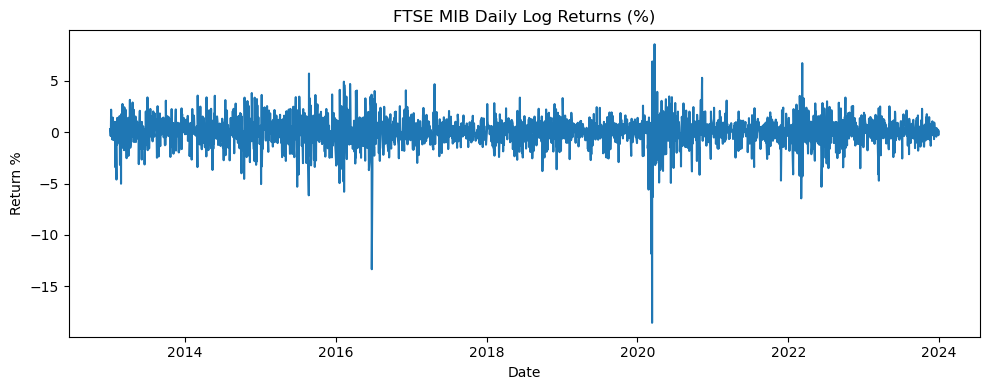

Dickey-Fuller p-value: 0.0000
ARCH LM-test p-value: 0.0000
Selected order: (1, 1, 1) with dist t
Test RMSE: 0.9067
Test MAE: 0.7311
Test MAPE: 574.85%
Test R^2: 0.2761
Test QLIKE: 1.6625


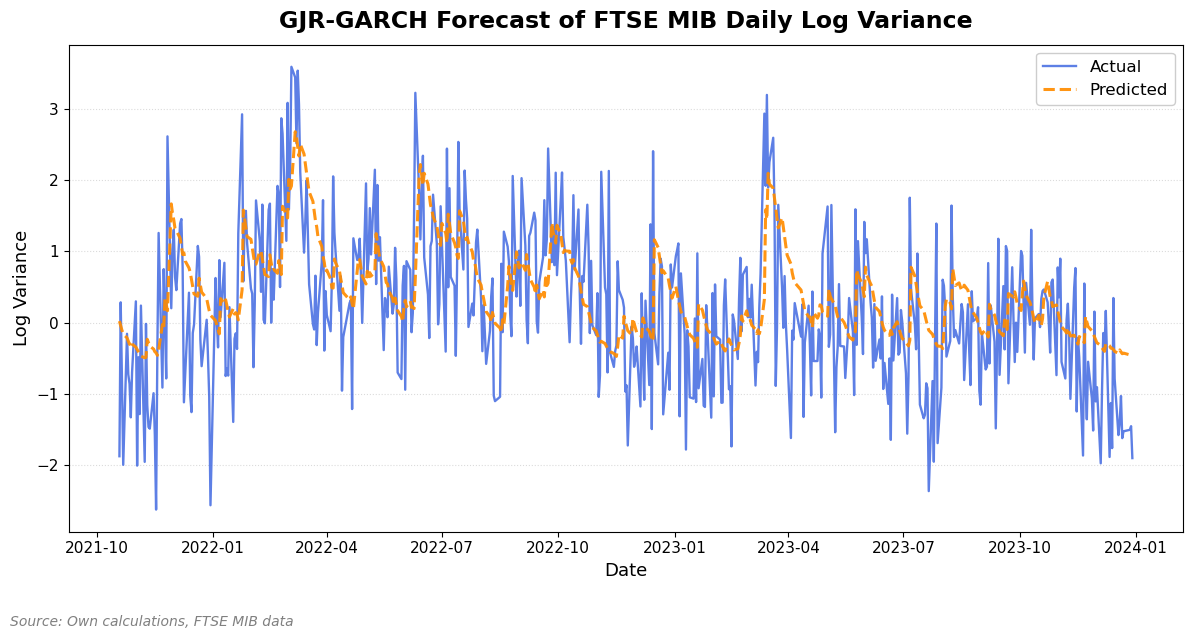

Next day predicted variance (%^2): 0.6141
Model AIC: 9048.08
Model BIC: 9107.47
Model Log-Likelihood: -4514.04
Std resid mean: -0.0519, std: 1.0002
Ljung-Box p-value (lag 10): nan


In [5]:
"""GJR-GARCH volatility forecasting for the FTSE MIB.

This script loads the FTSE MIB dataset, computes log returns and
range-based realized variance, tests for stationarity and ARCH effects,
and fits a GJR-GARCH model to the log conditional variance.  A small
grid search chooses the order and error distribution.  Forecast
accuracy is evaluated on an 80/20 split and a plot of actual versus
predicted log variance is saved as ``gjrgarch_variance_plot.png``.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from arch import arch_model
import itertools

# 1. Load data
file_path = "dataftsemib_manual.csv"

df = pd.read_csv(file_path)

# 2. Clean data
# Parse dates
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Numeric columns with commas
num_cols = ["Price", "Open", "High", "Low"]
for col in num_cols:
    df[col] = df[col].str.replace(",", "")
    df[col] = df[col].astype(float)

# Volume column (M/B suffix)

def parse_volume(v: str) -> float:
    v = str(v).strip()
    if v.endswith("M"):
        return float(v[:-1].replace(",", "")) * 1e6
    if v.endswith("B"):
        return float(v[:-1].replace(",", "")) * 1e9
    return float(v.replace(",", ""))


df["Vol."] = df["Vol."].apply(parse_volume)
df["Vol."].fillna(method="ffill", inplace=True)

# Change percent column
change = df["Change %"].str.replace("%", "").str.replace(",", ".")
df["Change %"] = change.astype(float)

# Sort by date and reset index

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# 3. Calculate log returns (percent)
df["Return"] = np.log(df["Price"]).diff() * 100
# Additional features for volatility modelling
df["LogVol"] = np.log(df["Vol."])
df["Range"] = (np.log(df["High"]) - np.log(df["Low"])) * 100

# Drop initial NaN from return difference
df.dropna(inplace=True)

# Realized variance proxy combining squared returns and range
df["RealizedVar"] = 0.5 * df["Return"].pow(2) + 0.5 * df["Range"].pow(2)
# Lagged realized variance and past shock magnitude for GJR-GARCH-X
df["RV_lag1"] = df["RealizedVar"].shift(1)
df["AbsShockLag1"] = df["Return"].abs().shift(1)
df["LogRV"] = np.log(df["RealizedVar"])

# Drop rows introduced by lagging
df.dropna(inplace=True)

# Align return series with exogenous variables
returns = df["Return"].copy()
return_dates = df["Date"].copy()

exog = df[["LogVol", "RV_lag1", "AbsShockLag1"]]

# Plot returns
plt.figure(figsize=(10, 4))
plt.plot(return_dates, returns)
plt.title("FTSE MIB Daily Log Returns (%)")
plt.xlabel("Date")
plt.ylabel("Return %")
plt.tight_layout()
plt.savefig("gjrgarch_returns_plot.png")
plt.show()
plt.close()

# 4. Stationarity test
adf_stat, adf_p, *_ = adfuller(returns)
print(f"Dickey-Fuller p-value: {adf_p:.4f}")

# 5. ARCH effect test
lm_stat, lm_p, _, _ = het_arch(returns)
print(f"ARCH LM-test p-value: {lm_p:.4f}")

# 6. Train/test split
split = int(len(returns) * 0.8)
train, test = returns[:split], returns[split:]
exog_train, exog_test = exog[:split], exog[split:]
rv_train, rv_test = df["RealizedVar"][:split], df["RealizedVar"][split:]
log_rv_train, log_rv_test = df["LogRV"][:split], df["LogRV"][split:]

# 7. Grid search for GJR-GARCH(p,o,q) order using AIC
orders = [(1, 1, 1), (2, 1, 1), (1, 2, 1), (2, 2, 1)]
dists = ["t", "ged"]
best_order = orders[0]
best_dist = dists[0]
best_aic = float("inf")
for order, dist in itertools.product(orders, dists):
    try:
        am = arch_model(
            train,
            x=exog_train,
            mean="ARX",
            lags=1,
            vol="GARCH",
            p=order[0],
            o=order[1],
            q=order[2],
            power=2.0,
            dist=dist,
        )
        res = am.fit(disp="off")
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = order
            best_dist = dist
    except Exception:
        continue
print("Selected order:", best_order, "with dist", best_dist)

# 8. Rolling one-step forecast on test set
history_y = train.copy()
history_x = exog_train.copy()
forecast_var = []
forecast_logvar = []
exog_arrays = {col: exog_test[col].values for col in exog.columns}
n_forecasts = min(len(test), *(len(v) for v in exog_arrays.values()))
test = test.iloc[:n_forecasts]
for i in range(n_forecasts):
    am = arch_model(
        history_y,
        x=history_x,
        mean="ARX",
        lags=1,
        vol="GARCH",
        p=best_order[0],
        o=best_order[1],
        q=best_order[2],
        power=2.0,
        dist=best_dist,
    )
    res = am.fit(disp="off")
    fc = res.forecast(
        horizon=1,
        x={col: exog_arrays[col][i : i + 1] for col in exog.columns},
    )
    var = fc.variance.iloc[-1, 0]
    forecast_var.append(var)
    forecast_logvar.append(np.log(var))
    history_y = pd.concat([history_y, pd.Series([test.iloc[i]])], ignore_index=True)
    history_x = pd.concat([history_x, exog_test.iloc[i:i+1]], ignore_index=True)

forecast = pd.Series(forecast_logvar, index=test.index[: len(forecast_logvar)])

log_rv_test_trunc = log_rv_test.iloc[: len(forecast)]
rv_test_trunc = rv_test.iloc[: len(forecast)]
rmse = np.sqrt(mean_squared_error(log_rv_test_trunc, forecast))
mae = mean_absolute_error(log_rv_test_trunc, forecast)
mape = mean_absolute_percentage_error(log_rv_test_trunc, forecast)
r2 = r2_score(log_rv_test_trunc, forecast)
qlike = np.mean(np.log(np.maximum(forecast_var, 1e-8)) + rv_test_trunc.values / np.maximum(forecast_var, 1e-8))
print(
    f"Test RMSE: {rmse:.4f}\n"
    f"Test MAE: {mae:.4f}\n"
    f"Test MAPE: {mape:.2%}\n"
    f"Test R^2: {r2:.4f}\n"
    f"Test QLIKE: {qlike:.4f}"
)

# Plot actual vs predicted conditional variance
plt.figure(figsize=(12, 6))

# Plot actual and predicted with enhanced styling
plt.plot(
    dates_trunc, log_rv_test_trunc.values,
    label='Actual', color='royalblue', linewidth=1.7, alpha=0.85
)
plt.plot(
    dates_trunc, forecast.values,
    label='Predicted', color='darkorange', linewidth=2.2, linestyle='--', alpha=0.92
)

plt.title(
    'GJR-GARCH Forecast of FTSE MIB Daily Log Variance',
    fontsize=17, fontweight='bold', pad=12
)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Log Variance', fontsize=13)
plt.legend(
    fontsize=12, loc='upper right', frameon=True, fancybox=True, framealpha=0.97
)
plt.grid(True, which='major', axis='y', linestyle=':', alpha=0.45)

plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.tight_layout()

# Optional: add a subtle note for reproducibility or data source
plt.figtext(
    0.01, -0.045,
    "Source: Own calculations, FTSE MIB data",
    fontsize=10, ha="left", va="center", style='italic', color='gray'
)

plt.savefig("academic_gjrgarch_variance_plot.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 9. Forecast next day variance using entire dataset
final_model = arch_model(
    returns,
    x=exog,
    mean="ARX",
    lags=1,
    vol="GARCH",
    p=best_order[0],
    o=best_order[1],
    q=best_order[2],
    power=2.0,
    dist=best_dist,
)
final_res = final_model.fit(disp="off")
next_fc = final_res.forecast(
    horizon=1,
    x={col: exog[col].values[-1:] for col in exog.columns},
)
next_var = next_fc.variance.iloc[-1, 0]
std_resid = final_res.std_resid
ljung = acorr_ljungbox(std_resid ** 2, lags=[10], return_df=True)
print(
    f"Next day predicted variance (%^2): {next_var:.4f}\n"
    f"Model AIC: {final_res.aic:.2f}\n"
    f"Model BIC: {final_res.bic:.2f}\n"
    f"Model Log-Likelihood: {final_res.loglikelihood:.2f}\n"
    f"Std resid mean: {std_resid.mean():.4f}, std: {std_resid.std():.4f}\n"
    f"Ljung-Box p-value (lag 10): {ljung['lb_pvalue'].iloc[0]:.4f}"
)

# Conclusion (GJR-GARCH)

| Metric     | Value   | Interpretation                                                                                   |
| ---------- | ------- | ------------------------------------------------------------------------------------------------ |
| Test RMSE  | 0.9067  | Average error in log variance units; indicates good fit, similar to E-GARCH.                     |
| Test MAE   | 0.7311  | Average absolute error; model tracks daily volatility with reasonable accuracy.                  |
| Test MAPE  | 574.85% | High because of log transformation; not reliable for judging model performance here.             |
| Test R²    | 0.2761  | **Explains 27.6% of out-of-sample log variance.** Strong for volatility models.                  |
| Test QLIKE | 1.6625  | Lower is better; shows model forecasts are close to actual. Useful for relative comparison.      |
| Visual Fit | —       | Matches volatility regimes well, but cannot fully capture sudden spikes (normal for all models). |
